In [14]:
import copy
import warnings
import networkx as nx
import numpy as np
from matplotlib import pyplot

from qiskit import QuantumCircuit, execute

try:
    from qiskit import Aer
    HAS_AER = True
except ImportError:
    from qiskit import BasicAer
    HAS_AER = False

In [15]:
class GraphDecoder():
    """
    Class to construct the graph corresponding to the possible syndromes
    of a quantum error correction code, and then run suitable decoders.
    """

    def __init__(self, d,T):
        self.d = d
        self.T = T
        self.S = {'X':nx.Graph(), 'Z':nx.Graph()}
        self.virtual = self._specify_virtual()
        self._make_syndrome_graph()
    
    def _specify_virtual(self):
        virtual = {}
        virtual['X'] = []
        virtual['Z'] = []
        for j in range(0,self.d,2):
            # X virtual nodes
            virtual['X'].append((-1,-.5,j-.5))
            virtual['X'].append((-1,self.d-.5,j+.5))
            
            # Z virtual nodes
            virtual['Z'].append((-1,j+.5,-.5))
            virtual['Z'].append((-1,j-.5,self.d-.5))
        return virtual
        
        
    def _make_syndrome_graph(self):
        """
        This method injects all possible Pauli errors into the circuit for
        ``code``.

        This is done by examining the qubits used in each gate of the
        circuit for a stored logical 0. A graph is then created with a node
        for each non-trivial syndrome element, and an edge between all such
        elements that can be created by the same error.
        """
        
        for t in  range(0,self.T):
            start_node_x = (.5,.5)
            self.S['X'].add_node((t,) + start_node_x,virtual=0, pos=(start_node_x[1], start_node_x[0]), time=t)
            start_node_z = (.5,1.5)
            self.S['Z'].add_node((t,) + start_node_z,virtual=0, pos=(start_node_z[1], start_node_z[0]), time=t)
            self.populate_syndrome_graph((t,) + start_node_x, t, [], 'X', edge_weight=1)
            self.populate_syndrome_graph((t,) + start_node_z, t, [], 'Z', edge_weight=1)

        for error_key in ['X','Z']:
            syndrome_nodes_t0 = [x for x,y in self.S[error_key].nodes(data=True) if y['time']==0]        
            for node in syndrome_nodes_t0:
                space_label = (node[1],node[2])
                for t in range(0,self.T-1):
                    self.S[error_key].add_edge((t,)+space_label, (t+1,)+space_label, distance=1)
                            
        
        
    def populate_syndrome_graph(self, current_node,t, visited_nodes, error_key,edge_weight=1):
        visited_nodes.append(current_node)
        neighbors = []
        i = current_node[1]
        j = current_node[2]
        neighbors.append((i-1, j-1))
        neighbors.append((i+1, j-1))
        neighbors.append((i-1, j+1))
        neighbors.append((i+1, j+1))

        normal_neighbors = [n for n in neighbors if self.valid_syndrome(n,error_key) and (t, n[0],n[1]) not in visited_nodes]
        virtual_neighbors = [n for n in neighbors if (-1,n[0],n[1]) in self.virtual[error_key] and (-1, n[0],n[1]) not in visited_nodes]
#         print(error_key)        
#         print("Current: " + str(current_node))
#         print("Normal: " + str(normal_neighbors))
#         print("Virtual: " + str(virtual_neighbors))
        
        if not normal_neighbors and not virtual_neighbors:
            return

        
        
        for target in normal_neighbors:
            target_node = (t,) + target
            if not self.S[error_key].has_node(target_node):
                self.S[error_key].add_node(target_node, virtual=0, pos=(target[1],target[0]), time=t)
            self.S[error_key].add_edge(current_node, target_node, distance=edge_weight)
        
        for target in virtual_neighbors:
            target_node = (-1,) + target
            if not self.S[error_key].has_node(target_node):
                self.S[error_key].add_node(target_node, virtual=1, pos=(target[1],target[0]), time=-1)
            self.S[error_key].add_edge(current_node, target_node, distance=edge_weight)
        
        for target in normal_neighbors:
            self.populate_syndrome_graph((t,) + target, t, visited_nodes,error_key,edge_weight=1)
        
        for target in virtual_neighbors:
            self.populate_syndrome_graph((-1,) + target, t, visited_nodes,error_key,edge_weight=1)
        
        return
        
    
    def valid_syndrome(self,node, error_key):
        i = node[0]
        j = node[1]
        if error_key == 'X':
            if i > 0 and i < self.d-1 and j < self.d and j > -1:
                return True
            else:
                return False
        elif error_key == 'Z':
            if j > 0 and j < self.d-1 and i < self.d and i > -1:
                return True
            else:
                return False
            
    def make_error_graph(self, nodes, error_key):
        virtual_dict = dict(self.S[error_key].nodes(data='virtual'))
        time_dict = dict(self.S[error_key].nodes(data='time'))
        error_graph = nx.Graph()
        nodes += self.virtual[error_key]
        for source in nodes:
            for target in nodes:
                if source != target:
                    for node in [source,target]:
                        if not error_graph.has_node(node):
                            error_graph.add_node(node, virtual=virtual_dict[node], pos=(node[2],node[1]), time=time_dict[node])
                    distance = int(nx.shortest_path_length(
                            self.S[error_key], source, target, weight='distance'))
                    error_graph.add_edge(source, target, weight=-distance)
        return error_graph
    
    def matching_graph(self, error_graph, error_key):
        time_dict = dict(self.S[error_key].nodes(data='time'))
        subgraph = nx.Graph()
        syndrome_nodes = [x for x,y in error_graph.nodes(data=True) if y['virtual']==0]
        virtual_nodes = [x for x,y in error_graph.nodes(data=True) if y['virtual']==1]
        
        for source in syndrome_nodes:
            for target in syndrome_nodes:
                if source != target:
                    for node in [source,target]:
                        if not subgraph.has_node(node):
                            subgraph.add_node(node, virtual=0, pos=(node[2],node[1]), time=time_dict[node])
                    subgraph.add_edge(source, target, weight=error_graph[source][target]['weight'])
                    
        for source in syndrome_nodes:
            potential_virtual = {}
            for target in virtual_nodes:
                potential_virtual[target] = error_graph[source][target]['weight']
            nearest_virtual = max(potential_virtual, key=potential_virtual.get)
            paired_virtual = nearest_virtual + source
            subgraph.add_node(paired_virtual, virtual=1, pos=(nearest_virtual[2],nearest_virtual[1]))
            subgraph.add_edge(
                source,
                paired_virtual,
                weight=potential_virtual[nearest_virtual])
            
        paired_virtual_nodes = [x for x,y in subgraph.nodes(data=True) if y['virtual']==1]
        
        for source in paired_virtual_nodes:
            for target in paired_virtual_nodes:
                subgraph.add_edge(
                source,
                target,
                weight=0)
        return subgraph
    
    def matching(self,matching_graph, error_key):
        matches = nx.max_weight_matching(matching_graph, maxcardinality=True)
        return matches
                
                
                
        
        

In [16]:
def graph_proper(G,edge_label):
    pos=nx.get_node_attributes(G,'pos')
    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(G,edge_label)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    pyplot.gca().invert_yaxis()

In [19]:
decoder = GraphDecoder(3,1)

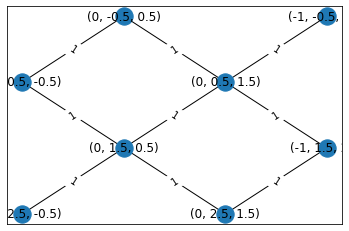

In [20]:
G = decoder.S['Z']
graph_proper(G,'distance')

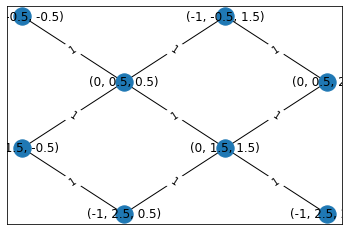

In [21]:
G = decoder.S['X']
graph_proper(G,'distance')

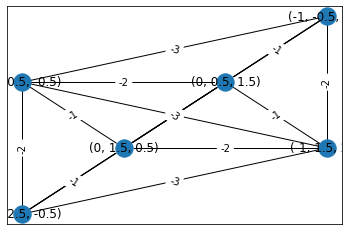

In [22]:
node_set = [(0,1.5,.5),(0,.5,1.5)]
error_graph = decoder.make_error_graph(node_set,'Z')
graph_proper(error_graph,'weight')#note that some edges overlap

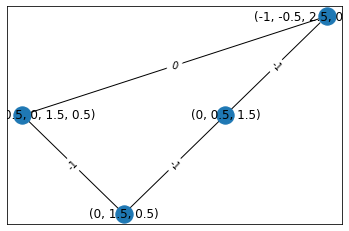

In [23]:
matching_graph = decoder.matching_graph(error_graph,'Z')
graph_proper(matching_graph,'weight')

In [24]:
g = decoder.matching(matching_graph,'Z')
for e in g:
    print(e)

((-1, -0.5, 2.5, 0, 0.5, 1.5), (-1, 0.5, -0.5, 0, 1.5, 0.5))
((0, 1.5, 0.5), (0, 0.5, 1.5))


In [25]:
decoder = GraphDecoder(9,1)

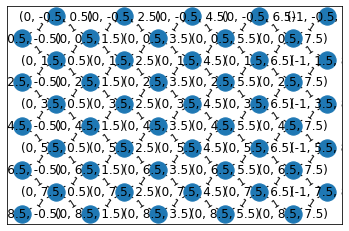

In [26]:
G = decoder.S['Z']
graph_proper(G,'distance')

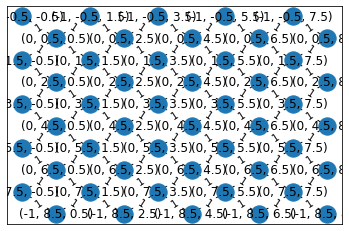

In [27]:
G = decoder.S['X']
graph_proper(G,'distance')

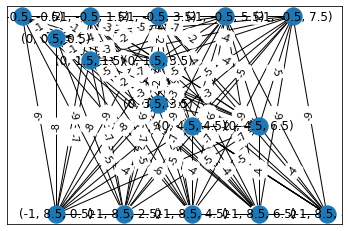

In [28]:
node_set = [(0,0.5,0.5),(0,1.5,1.5),(0,1.5,3.5),(0,3.5,3.5),(0,4.5,4.5),(0,4.5,6.5)]
error_graph = decoder.make_error_graph(node_set,'X')
graph_proper(error_graph,'weight')#note that some edges overlap

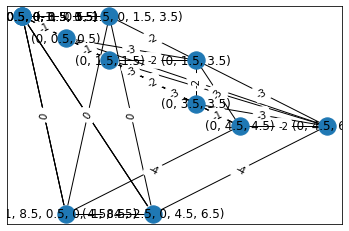

In [29]:
matching_graph = decoder.matching_graph(error_graph,'X')
graph_proper(matching_graph,'weight')

In [31]:
g = decoder.matching(matching_graph,'X')
for e in g:
    print(e)

((-1, 8.5, 0.5, 0, 4.5, 4.5), (-1, -0.5, -0.5, 0, 1.5, 1.5))
((-1, -0.5, -0.5, 0, 3.5, 3.5), (-1, -0.5, 1.5, 0, 1.5, 3.5))
((0, 1.5, 1.5), (0, 0.5, 0.5))
((-1, 8.5, 2.5, 0, 4.5, 6.5), (-1, -0.5, -0.5, 0, 0.5, 0.5))
((0, 3.5, 3.5), (0, 4.5, 4.5))
((0, 4.5, 6.5), (0, 1.5, 3.5))


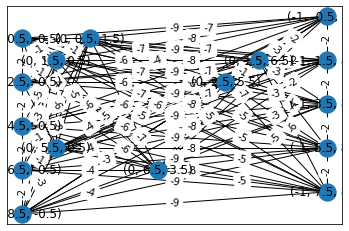

In [32]:
node_set = [(0,1.5,0.5),(0,0.5,1.5),(0,1.5,6.5),(0,2.5,5.5),(0,5.5,.5),(0,6.5,3.5)]
error_graph = decoder.make_error_graph(node_set,'Z')
graph_proper(error_graph,'weight')#note that some edges overlap

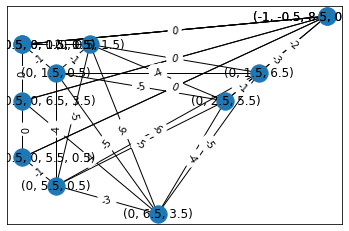

In [34]:
matching_graph = decoder.matching_graph(error_graph,'Z')
graph_proper(matching_graph,'weight')

In [35]:
g = decoder.matching(matching_graph,'X')
for e in g:
    print(e)

((-1, 2.5, -0.5, 0, 6.5, 3.5), (-1, 0.5, -0.5, 0, 1.5, 0.5))
((-1, 4.5, -0.5, 0, 5.5, 0.5), (-1, 0.5, -0.5, 0, 0.5, 1.5))
((-1, -0.5, 8.5, 0, 2.5, 5.5), (-1, -0.5, 8.5, 0, 1.5, 6.5))
((0, 1.5, 6.5), (0, 2.5, 5.5))
((0, 1.5, 0.5), (0, 0.5, 1.5))
((0, 6.5, 3.5), (0, 5.5, 0.5))
